# Replication: Zeighami *et al*, 2019

## Introduction

This notebook attempts to reproduce the following paper (which already uses the [PPMI](http://ppmi-info.org) dataset):

<div class="alert alert-block alert-success">
Zeighami, Yashar, et al. <a href=https://doi.org/10.1016/j.nicl.2019.101986>Assessment of a prognostic MRI biomarker in early de novo Parkinson's disease.</a> NeuroImage: Clinical 24 (2019): 101986.
</div>

This study used longitudinal MRI data from 362 patients with de novo PD (i.e., patients not yet taking any medication) and 112 healthy controls. Subjects were split into a main cohort with 3T MRI scans (222 PD patients, 112 healthy controls) and a validation cohort with 1.5T MRI scans (140 PD patients). 

The demographics parameters for the PD patients were as follows (table extracted from the paper):

<img src="images/demographics.png" width=800/>

This paper used a method introduced in [Zeighami *et al* (2015)](https://doi.org/10.7554/eLife.08440) consisting of applying Independent Component Analysis (ICA) to Deformation-Based Morphometry (DBM) maps to identify an atrophy network related to PD. The main result is atrophy measures from this PD network is significantly correlated with disease progression as measured by differences in clinical and/or cognitive scores between the baseline visit and the most recent follow-up visit. This is illustrated in the top row of the following table (extracted from the paper):

<img src="images/results_correlations.png" width=600/>

The authors also showed that the PD-related atrophy score can be used to identify patients who have a 1.5 standard deviation change in the global composite outcome (a measure they defined) between baseline and follow-up visits. The PD-related atrophy biomarker achieved an area under the receiver operating characteristics (ROC) curve of 0.63, out-performing other biomarkers, as shown in the figure below (extracted from the paper):

<img src="images/results_AUC.png" width=500/>

The remainder of this notebook is an attempt to reproduce these results using the same PPMI dataset.

## Initial setup

We first initialize the notebook cache and install dependencies:

In [1]:
import livingpark_utils

utils = livingpark_utils.LivingParkUtils()
utils.notebook_init()

removing link inputs
removing link outputs
Installing notebook dependencies (see log in install.log)... 
This notebook was run on 2022-10-07 18:57:41 UTC +0000


We import required libraries and functions:

In [2]:
import re
from functools import reduce

import numpy as np
import pandas as pd

We also load some constants and helper functions that will be used in the rest of the notebook:

In [3]:
from livingpark_utils.zeighamietal.constants import (
    FILENAME_PARTICIPANT_STATUS,
    FILENAME_DEMOGRAPHICS,
    FILENAME_AGE,
    FILENAME_MOCA,
    FILENAME_UPDRS2,
    FILENAME_UPDRS3,
    FILENAME_ADL,
    FILENAME_T1_INFO,
)

from livingpark_utils.zeighamietal.constants import (
    COL_PAT_ID, COL_STATUS, COL_VISIT_TYPE, COL_DATE_INFO,
)

from livingpark_utils.zeighamietal.constants import (
    STATUS_PD, STATUS_HC, MAIN_COHORT, VALIDATION_COHORT,
    VISIT_BASELINE, VISIT_SCREENING, REGEX_VISIT_FOLLOWUP, 
    SEX_FEMALE, SEX_MALE, MAX_DATES,
)

from livingpark_utils.zeighamietal.constants import (
    COL_PD_STATE, COL_AGE, COL_SEX, COL_EDUCATION,
    COL_MOCA, COL_ADL, COL_UPDRS2, COL_UPDRS3, COL_PIGD, COL_GCO,
    COLS_PIGD_COMPONENTS_UPDRS2, COLS_PIGD_COMPONENTS_UPDRS3, COLS_PIGD_COMPONENTS, 
    COLS_SCORES, COLS_SCORES_WITHOUT_GCO,
    COL_FOLLOWUP,
)

from livingpark_utils.zeighamietal import (
    load_ppmi_csv, 
    get_t1_cohort,
    mean_impute,
    filter_date, 
)

We fix the random seed to make sure we get the same results everytime:

In [4]:
random_seed = 1

## PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study (Table 1) as closely as possible. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Study data download

We will start by downloading the PPMI Study Data files required to build our cohort: 

* Participant status (Parkinson's disease, healthy control, etc.)
* Demographics
* Age at visit
* Clinical/cognitive assessment results:
    * Montreal Cognitive Assessment (MoCA)
    * Unified Parkinson's Disease Rating Scale (UPDRS) Part II and Part III
    * Modified Schwab and England Activities of Daily Living scale

We will use the LivingPark utils library to download these files from the notebook. If files are already present in the notebook cache, they won't be downloaded again. Otherwise, you will need to enter your PPMI username and password. In case you don't have a PPMI account, you can request one [here](http://ppmi-info.org).

In [5]:
required_files = [
    FILENAME_PARTICIPANT_STATUS,
    FILENAME_DEMOGRAPHICS,
    FILENAME_AGE,
    FILENAME_MOCA,
    FILENAME_UPDRS2,
    FILENAME_UPDRS3,
    FILENAME_ADL,
]

utils.download_ppmi_metadata(required_files)

Download skipped: No missing files!


### Subjects with T1 MRI available

The paper uses a main cohort and a validation cohort. The **main cohort** consists of subjects with 3T T1 scans and is a subset of the cohort the authors used in the 2015 paper. The **validation cohort** consists of subjects with 1.5T T1 scans.

***Main cohort***

The main cohort was made up of of 222 PD patients and 112 healthy controls. In the 2015 paper, the authors used data from 237 PD patients and 118 healthy controls. MRI processing failure led to the exclusion of 5 PD patients and 1 healthy control, and so the final cohort consisted of 232 PD patients and 117 healthy controls. In the 2019 paper, an additional 10 PD patients and 5 healthy controls were excluded due to lack of follow-up data required in the analysis.

*Note*: In the 2015 paper, the authors state that they used scans acquired from September 2013 to January 2014. However, if we restrict our search to this time period, the number of available scans is much lower than expected (38 PD patients instead of 237, 1 healthy control instead of 118). If we instead use all subjects with 3T scans from January 31st 2014 and before, we obtain 236 PD patients and 113 healthy controls, which is closer to what we expect thought still not exactly the same.

***Validation cohort***

The validation cohort was made up of 140 PD patients. The paper states that data were downloaded in October 2017, so we use all subjects with 1.5T scans from October 31st 2017 and before. 

In [6]:
df_status = load_ppmi_csv(utils, FILENAME_PARTICIPANT_STATUS)

cohort_t1_map = {}
for cohort_name in [MAIN_COHORT, VALIDATION_COHORT]:

    print(f"=============== {cohort_name.capitalize()} cohort ===============")

    df_t1_subset = get_t1_cohort(
        utils, 
        cohort_name=cohort_name,
        filename=FILENAME_T1_INFO,
        sagittal_only=True,
    )
    cohort_t1_map[cohort_name] = df_t1_subset

    # cohort composition: number of PD patients/healthy controls
    print(
        df_status.loc[
            df_status[COL_PAT_ID].isin(df_t1_subset[COL_PAT_ID]), COL_STATUS
        ].value_counts()
    )

=============== Main cohort ===============
Removing extra scans for 1 subjects
Parkinson's Disease    236
Healthy Control        113
Name: COHORT_DEFINITION, dtype: int64
=============== Validation cohort ===============
Removing extra scans for 3 subjects
Parkinson's Disease    130
Name: COHORT_DEFINITION, dtype: int64


### Remove subjects with no follow-up data available

The original paper excluded participants with less than 1 year of follow-up:
* 10 PD patients and 5 healthy controls from their main cohort
* No subjects were removed from the validation cohort

We will identify subjects with less than 1 year of follow-up for the PD progression measures.

First, we load/compute and merge all the required clinical/cognitive measures:
* UPDRS Part II
* UPDRS Part III
* Modified Schwab and England Activities of Daily Living (ADL) scale
* Postural instability and gait disturbance (PIGD) score
* MoCA

Missing values are imputed with the mean across the entire dataset, except for the MoCA score (handled below).

The PIGD score is defined in [Stebbins et al. 2013](https://doi.org/10.1002/mds.25383) and consists of the mean of a subset of UPDRS (Part II and III) measures.

In [7]:
cols_for_merge = [COL_PAT_ID, COL_DATE_INFO, COL_VISIT_TYPE]

df_updrs2 = load_ppmi_csv(utils, FILENAME_UPDRS2, cols_to_impute=COLS_PIGD_COMPONENTS_UPDRS2+[COL_UPDRS2])
df_updrs3 = load_ppmi_csv(utils, FILENAME_UPDRS3, cols_to_impute=COLS_PIGD_COMPONENTS_UPDRS3+[COL_UPDRS3])
df_adl = load_ppmi_csv(utils, FILENAME_ADL, cols_to_impute=COL_ADL)
df_moca = load_ppmi_csv(utils, FILENAME_MOCA) # do not impute

# some subjects in the validation cohort have multiple entries on the same date
# one for PDSTATE=ON and one for PDSTATE=OFF
# we drop rows where PDSTATE is OFF
# PDSTATE=OFF is the typical functional state when participants have a poor response in spite of taking medications
# PDSTATE=ON is the typical functional state when patients are receiving medication and have a good response
# TODO check
df_updrs3 = df_updrs3.loc[df_updrs3[COL_PD_STATE] != "OFF"]

# PIGD score is build from UPDRS (Stebbins et al. 2013)
df_pigd = df_updrs2.merge(df_updrs3, on=cols_for_merge, how="inner")
df_pigd[COL_PIGD] = df_pigd.loc[:, COLS_PIGD_COMPONENTS].mean(axis="columns")

df_moca = df_moca.loc[:, cols_for_merge + [COL_MOCA]]
df_adl = df_adl.loc[:, cols_for_merge + [COL_ADL]]
df_updrs2 = df_updrs2.loc[:, cols_for_merge + [COL_UPDRS2]]
df_updrs3 = df_updrs3.loc[:, cols_for_merge + [COL_UPDRS3]]
df_pigd = df_pigd.loc[:, cols_for_merge + [COL_PIGD]]

df_assessments_all = reduce(
    lambda df1, df2: df1.merge(df2, on=cols_for_merge, how="outer"),
    [df_updrs2, df_updrs3, df_adl, df_pigd, df_moca],
).drop_duplicates()

# some missing values remain even if we use the screening visit score
# we will impute these using the original mean
mean_moca = df_moca[COL_MOCA].mean()

cols_to_impute = [col for col in COLS_SCORES_WITHOUT_GCO if col != COL_MOCA]
df_assessments_all = mean_impute(df_assessments_all, cols_to_impute)

# keep only subjects who have a T1
cohort_assessments_map_orig = {}
for cohort_name, df_t1_subset in cohort_t1_map.items():
    cohort_assessments_map_orig[cohort_name] = df_assessments_all.loc[
        df_assessments_all[COL_PAT_ID].isin(df_t1_subset[COL_PAT_ID])
    ]

Most subjects (including all subjects in the main cohort) took the MoCA during the screening visit, not the baseline visit. We replace the baseline MoCA score by the one from the screening visit. We plot a histogram for the number of days between baseline and screening visits, so check whether it was reasonable to use the screening visit score if the baseline score was not available.

========== MAIN COHORT ==========
Parkinson's Disease    227
Healthy Control        109
Name: COHORT_DEFINITION, dtype: int64
========== VALIDATION COHORT ==========
Parkinson's Disease    128
Name: COHORT_DEFINITION, dtype: int64


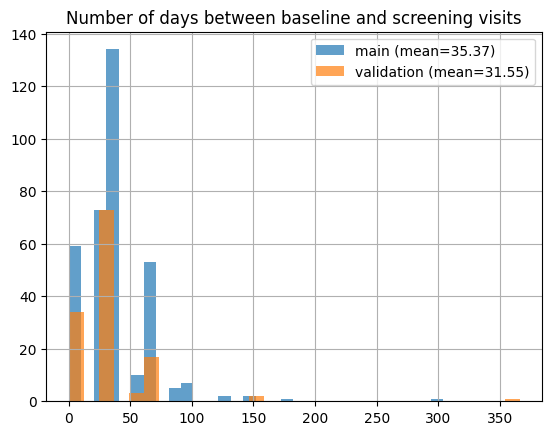

In [8]:
col_date_diff = "date_diff"
max_date_followup = MAX_DATES[VALIDATION_COHORT]

re_followup_compiled = re.compile(REGEX_VISIT_FOLLOWUP)

cohort_assessments_map = {}
for cohort_name in cohort_assessments_map_orig:

    print(f"========== {cohort_name.upper()} COHORT ==========")

    date_diffs = []

    df_assessments_cohort: pd.DataFrame = cohort_assessments_map_orig[cohort_name]
    df_assessments_baseline = df_assessments_cohort.loc[
        df_assessments_cohort[COL_VISIT_TYPE] == VISIT_BASELINE
    ]
    df_assessments_screening = df_assessments_cohort.loc[
        df_assessments_cohort[COL_VISIT_TYPE] == VISIT_SCREENING
    ]

    # try to fill in missing baseline data
    for idx_row_baseline, row_baseline in df_assessments_baseline.iterrows():

        subject = row_baseline[COL_PAT_ID]
        date_baseline = row_baseline[COL_DATE_INFO]

        # for each score columns
        for col in [COL_MOCA]:

            # fill missing values with screening data
            if pd.isna(row_baseline[col]):

                df_screening_subject = df_assessments_screening.loc[
                    df_assessments_screening[COL_PAT_ID] == subject
                ]

                # some subjects in validation set had multiple screening visits
                # in this case we sort them by how close they are to the baseline visit
                n_screening = len(df_screening_subject)
                if n_screening > 1:
                    df_screening_subject[col_date_diff] = (
                        date_baseline - df_screening_subject[COL_DATE_INFO]
                    )
                    df_screening_subject = df_screening_subject.sort_values(
                        col_date_diff, ascending=True
                    )

                # find corresponding assessment score in screening visits
                for idx_row_screening, row_screening in df_screening_subject.iterrows():
                    new_value = row_screening[col]
                    date_diff = date_baseline - row_screening[COL_DATE_INFO]
                    if not pd.isna(new_value):
                        break

                # replace
                if not pd.isna(new_value):
                    df_assessments_baseline.loc[idx_row_baseline, col] = new_value
                    date_diffs.append(date_diff.days)  # for plotting

    # plot baseline-screening date difference
    date_diffs = pd.Series(date_diffs)
    ax = date_diffs.hist(
        bins=30, alpha=0.7, label=f"{cohort_name} (mean={date_diffs.mean():.2f})"
    )

    # we only use regular, scheduled follow-up visit (code V01-V20)
    df_assessments_followup = df_assessments_cohort.loc[
        (df_assessments_cohort[COL_PAT_ID].isin(df_assessments_baseline[COL_PAT_ID]))
        & (
            df_assessments_cohort[COL_VISIT_TYPE].apply(
                lambda v: re_followup_compiled.match(v)
            )
        )
    ]

    # keep most recent follow-up data up to October 2017
    df_assessments_followup = filter_date(
        df_assessments_followup, max_date=max_date_followup
    )
    df_assessments_followup = (
        df_assessments_followup.groupby(COL_PAT_ID)
        .apply(lambda df: df.sort_values(COL_DATE_INFO, ascending=False).head(1))
        .reset_index(drop=True)
    )

    # we keep subjects who have both baseline and follow-up data
    subjects_common = set(df_assessments_cohort[COL_PAT_ID])
    for df_visit in [df_assessments_baseline, df_assessments_followup]:
        subjects_common = subjects_common & set(df_visit[COL_PAT_ID])

    # print cohort composition
    print(
        df_status.loc[df_status[COL_PAT_ID].isin(subjects_common), COL_STATUS].value_counts()
    )

    # combine baseline and follow-up
    df_assessments_baseline[COL_FOLLOWUP] = False
    df_assessments_followup[COL_FOLLOWUP] = True
    df_assessments_merged = pd.concat(
        [df_assessments_baseline, df_assessments_followup], axis="index"
    )
    df_assessments_merged = df_assessments_merged.loc[
        df_assessments_merged[COL_PAT_ID].isin(subjects_common)
    ]

    # impute remaining missing MoCA values
    df_assessments_merged.loc[df_assessments_merged[COL_MOCA].isna(), COL_MOCA] = mean_moca

    cohort_assessments_map[cohort_name] = df_assessments_merged

# note: date resolution is months
ax.set_title("Number of days between baseline and screening visits")
ax.legend()

Now we compute the global composite outcome, which is the average of the z-scores of the other measures. Following the original paper, we use the mean and standard deviation of the baseline session to compute the z-scores:

In [9]:
for cohort_name, df_assessments in cohort_assessments_map.items():
    df_assessments_baseline = df_assessments.loc[
        ~df_assessments[COL_FOLLOWUP], COLS_SCORES_WITHOUT_GCO
    ]
    gco_means = df_assessments_baseline.mean()
    gco_stds = df_assessments_baseline.std()
    gco = ((df_assessments[COLS_SCORES_WITHOUT_GCO] - gco_means) / gco_stds).mean(
        axis="columns"
    )
    cohort_assessments_map[cohort_name][COL_GCO] = gco

We check average time between baseline and follow-up. In the original paper they report an average of 4.5 years.

In [10]:
dfs_duration = []
for df_assessments in cohort_assessments_map.values():
    dfs_duration.append(
        df_assessments.groupby(COL_PAT_ID).apply(
            lambda df: (
                df.loc[df[COL_FOLLOWUP], COL_DATE_INFO].item()
                - df.loc[~df[COL_FOLLOWUP], COL_DATE_INFO].item()
            )
        )
    )

df_duration = pd.concat(dfs_duration)
print(
    f'{df_duration.mean().days / 365:.3f} '
    f'(\u00B1 {df_duration.std().days / 365:.3f}) years'
)

4.545 (± 1.247) years


Finally, we create a demographics table similar to the one in the original paper

In [11]:
def to_1_decimal_str(f):
    return str(round(f, 1))

df_age = load_ppmi_csv(utils, FILENAME_AGE)
df_demographics = load_ppmi_csv(utils, FILENAME_DEMOGRAPHICS)

col_male = "is_male"
col_cohort = 'cohort'

dfs_summary = []
df_assessments: pd.DataFrame
for cohort_name, df_assessments in cohort_assessments_map.items():

    subjects = df_assessments[COL_PAT_ID].drop_duplicates()
    subjects_pd = df_status.loc[
        (df_status[COL_PAT_ID].isin(subjects)) & (df_status[COL_STATUS] == STATUS_PD),
        COL_PAT_ID,
    ]

    # the paper only report measures for the PD patients
    df_assessments = df_assessments.loc[df_assessments[COL_PAT_ID].isin(subjects_pd)]

    # general demographics (baseline session only)
    df_summary = df_assessments.merge(df_age, on=[COL_PAT_ID, COL_VISIT_TYPE])
    df_demographics[col_male] = (df_demographics[COL_SEX] == SEX_MALE).apply(lambda v: 100 if v else 0)
    df_summary = df_summary.merge(df_demographics, on=COL_PAT_ID)
    df_summary = df_summary[[COL_PAT_ID, COL_AGE, col_male]]
    df_summary[COL_FOLLOWUP] = False

    # combine with clinical/cognitive scores
    df_summary = df_summary.merge(df_assessments, on=[COL_PAT_ID, COL_FOLLOWUP], how='outer')
    df_summary = df_summary.drop(columns=COL_PAT_ID)

    # append
    df_summary[col_cohort] = cohort_name
    dfs_summary.append(df_summary)

df_summary = pd.concat(dfs_summary)
df_summary_means = df_summary.groupby([col_cohort, COL_FOLLOWUP]).mean().applymap(to_1_decimal_str)
df_summary_stds = df_summary.groupby([col_cohort, COL_FOLLOWUP]).std().applymap(to_1_decimal_str)
df_summary_stds = ' (' + df_summary_stds + ')'
df_summary_stds.loc[:, col_male] = ''
df_summary_combined = (df_summary_means + df_summary_stds).T
df_summary_combined = df_summary_combined.applymap(lambda x: '-' if 'nan' in x else x)
df_summary_combined = df_summary_combined.rename(index={
    COL_AGE: 'Age',
    col_male: 'Male (%)',
    COL_UPDRS2: 'UPDRS Part II',
    COL_UPDRS3: 'UPDRS Part III',
    COL_ADL: 'S&E ADL',
    COL_PIGD: 'PIGD',
    COL_MOCA: 'MoCA',
    COL_GCO: 'Global composite outcome',
})
df_summary_combined

cohort                          main                validation             
is_followup                    False        True         False        True 
Age                       63.5 (9.6)            -  65.0 (10.3)            -
Male (%)                        63.9            -         60.2            -
UPDRS Part II              5.7 (4.0)   10.7 (7.4)    6.2 (4.4)   10.6 (6.9)
UPDRS Part III            21.6 (9.0)  25.1 (13.0)   19.0 (8.4)  23.5 (11.4)
S&E ADL                   93.4 (5.7)  86.0 (12.0)   92.1 (6.0)  82.4 (12.8)
PIGD                       0.2 (0.2)    0.5 (0.6)    0.3 (0.2)    0.5 (0.5)
MoCA                      27.4 (2.1)   26.4 (3.3)   26.4 (2.7)   26.1 (3.1)
Global composite outcome   0.2 (0.4)    0.4 (0.6)    0.0 (0.4)    0.2 (0.7)